In [12]:
import requests
from matplotlib import pyplot as plt
import os
import pickle
import pandas as pd
from ipyleaflet import Map, Polyline, Heatmap
from random import uniform

In [29]:
def initialize_data_dir():
    path = './data'
    if not os.path.isdir(path):
        try:  
            os.mkdir(path)
        except OSError:  
            print ("Creation of the directory %s failed" % path)
            return False

        loaded_tracks = set()
        with open(path+'/loaded_tracks.pkl', 'wb') as out:
            pickle.dump(loaded_tracks, out, pickle.HIGHEST_PROTOCOL)
            del loaded_tracks

        columns = ['track_id', 'length', 'feature_id', 'time', 'lattitude', 'longitude', 'consumption', 'speed', 'altitude', 'engine_load', 'accuracy', 'co2']
        local_tracks = pd.DataFrame(columns = columns)
        local_tracks.to_pickle(path+'/tracks.pkl')
        del local_tracks

def load_data():
    path = './data'
    initialize_data_dir()
    with open(path+'/loaded_tracks.pkl', 'rb') as ip:
        loaded_tracks = pickle.load(ip)
    local_tracks = pd.read_pickle(path+'/tracks.pkl')

    page_no = 1
    n_new_tracks = 0
    load = True
    while load:
        new_tracks = requests.get('https://envirocar.org/api/stable/tracks?limit=1000&page='+str(page_no))
        new_tracks = new_tracks.json()
        for i in range(0, len(new_tracks['tracks'])):
            new_track_id = new_tracks['tracks'][i]['id']
            if new_track_id in loaded_tracks:
                load = False
                break
            else:
                #print(str(page)+' '+str(j)+' '+str(resp['tracks'][j]['id']))
                loaded_tracks.add(new_track_id)
                new_track = requests.get('https://envirocar.org/api/stable/tracks/'+new_track_id)
                new_track = new_track.json()
                length = new_track['properties']['length']
                for i in range(0, len(new_track['features'])):
                    feature = new_track['features'][i]
                    feature_id = feature['properties']['id']
                    time = feature['properties']['time']
                    lattitude = feature['geometry']['coordinates'][0]
                    longitude = feature['geometry']['coordinates'][1]
                    try:
                        consumption = feature['properties']['phenomenons']['Consumption']['value']
                    except KeyError:
                        consumption = None
                    try:
                        speed = feature['properties']['phenomenons']['Speed']['value']
                    except KeyError:
                        speed = None
                    try:
                        altitude = feature['properties']['phenomenons']['GPS Altitude']['value']
                    except KeyError:
                        altitude = None
                    try:
                        engine_load = feature['properties']['phenomenons']['Engine Load']['value']
                    except KeyError:
                        engine_load = None
                    try:
                        accuracy = feature['properties']['phenomenons']['GPS Accuracy']['value']
                    except KeyError:
                        accuracy = None
                    try:
                        co2 = feature['properties']['phenomenons']['CO2']['value']
                    except KeyError:
                        co2 = None
                    local_tracks.loc[local_tracks.shape[0]] = [new_track_id, length, feature_id, time, lattitude, longitude, consumption, speed, altitude, engine_load, accuracy, co2]
                n_new_tracks += 1
        #print(page_no)
        page_no += 1
    with open(path+'/loaded_tracks.pkl', 'wb') as out:
        pickle.dump(loaded_tracks, out, pickle.HIGHEST_PROTOCOL)
    del loaded_tracks
    local_tracks.to_pickle(path+'/tracks.pkl')        
    print('%d new tracks are loaded' % n_new_tracks)
    print('Total number of tracks = %d' % local_tracks.shape[0])
    del local_tracks

In [30]:
load_data()

1000 new tracks are loaded
Total number of tracks = 409040


In [31]:
tracks = pd.read_pickle('./data/tracks.pkl')
tracks['track_id'].unique()

array(['5c94012c44ea85030257e639', '5c93d27344ea8503020fdeb0',
       '5c93d27244ea8503020fd8ee', '5c93d26e44ea8503020fd5f0',
       '5c93d26944ea8503020fd45f', '5c93d26744ea8503020fcb86',
       '5c93d26544ea8503020fcb4f', '5c9351f044ea850302b6ac7a',
       '5c9351f044ea850302b6a310', '5c9351eb44ea850302b686d7',
       '5c934f9844ea850302b66b61', '5c932b3644ea850302a99dd0',
       '5c92918d44ea850302a1dc53', '5c928d3c44ea850302a1db39',
       '5c92887344ea850302a1d542', '5c92851344ea850302a19f71',
       '5c92686b44ea850302a07322', '5c91de1344ea850302829b63',
       '5c91572e44ea850302818a62', '5c914e2d44ea850302816c0a',
       '5c9127a544ea8503028157cf', '5c91276944ea8503028156e2',
       '5c91272844ea85030281568b', '5c91270d44ea85030281536d',
       '5c90f86644ea8503028125ed', '5c90ed6944ea850302812081',
       '5c90ed6544ea8503028112d3', '5c8fb75644ea8503027db648',
       '5c8f3e9644ea8503027c30ca', '5c8e55f344ea85030270ca22',
       '5c8e112644ea8503026cdf07', '5c8e0f6644ea8503026

In [32]:
with open('./data/loaded_tracks.pkl', 'rb') as input:
    loaded_tracks = pickle.load(input)
m = Map(center = (tracks['longitude'].mean(), tracks['lattitude'].mean()), zoom=8)
point_set = []
for t_id in loaded_tracks:
    df = tracks.loc[tracks['track_id'] == t_id]
    points = list()
    for i in range(0, df.shape[0]):
        points.append([df.iloc[i]['longitude'], df.iloc[i]['lattitude']])
    point_set.append(points)
line = Polyline(locations = [point_set], fill=False, opacity=0.5)
m.add_layer(line)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [33]:
m = Map(center=(tracks['longitude'].mean(), tracks['lattitude'].mean()), zoom=8)
point_set = []
for i in range(0, tracks.shape[0]):
    points = [tracks.iloc[i]['longitude'], tracks.iloc[i]['lattitude'], tracks.iloc[i]['altitude']]
    point_set.append(points)
heatmap = Heatmap(locations=point_set,radius=5)
m.add_layer(heatmap);
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

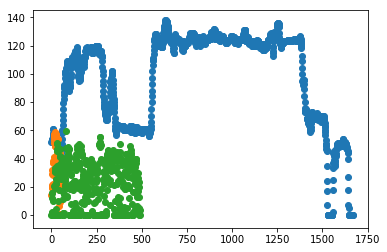

In [34]:
t_id = '5c94012c44ea85030257e639'
df = tracks.loc[tracks['track_id'] == t_id]
plt.scatter(range(0, df.shape[0]), df['speed'].tolist())
t_id = '5c93d27344ea8503020fdeb0'
df = tracks.loc[tracks['track_id'] == t_id]
plt.scatter(range(0, df.shape[0]), df['speed'].tolist())
t_id = '5c93d27244ea8503020fd8ee'
df = tracks.loc[tracks['track_id'] == t_id]
plt.scatter(range(0, df.shape[0]), df['speed'].tolist())